# Машинное обучение, ФКН ВШЭ

# Практическое задание 6. Бустинговое

## Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 24.12.2023 23:59 MSK

Жёсткий дедлайн: 24.12.2023 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг.

In [126]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style='darkgrid')
filterwarnings('ignore')

In [127]:
x = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 1337 для воспроизводимости).

In [128]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустингового (4 балла)

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

В `__init__` приходит кучка параметров, распишем что есть что:

 - `base_model_class` - класс базовой модели нашего бустинга
 - `base_model_params` - словарь с гиперпараметрами для базовой модели
 - `n_estimators` - какое количество базовых моделей нужно обучить
 - `learning_rate` - темп обучения, должен быть из полуинтервала $(0, 1]$
 - `subsample` - доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей)
 - `early_stopping_rounds` - число итераций, после которых при отсутствии улучшения качества на валидационной выборке обучение останавливается
 - `plot` - строить ли после обучения всех базовых моделей график с качеством

#### `fit`

В `fit` приходит две выборки, обучающая и валидационная. На обучающей мы обучаем новые базовые модели, на валидационной считаем качество для ранней остановки (если это предусматривают параметры).

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания для обучающей и валидационной выборок (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на обучающей и валидационной выборках (используем `loss_fn` для этого), проверить на раннюю остановку.

После всего цикла обучения надо нарисовать график (если `plot`).


#### `fit_new_base_model`

В `fit_new_base_model` приходит обучающая выборка (целиком) и текущие предсказания для неё. Мы должны сгенерировать бутстрап выборку для обучения базовой модели и обучить базовую модель. После обучения модели запускаем поиск оптимальной гаммы, добавляем новую модель и гамму (не забываем про темп обучения) в соответствующие списки.

#### `predict_proba`

В `predict_proba` приходит выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду.

In [135]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
from scipy.optimize import minimize_scalar

def score(clf, x, y):
    return roc_auc_score(y == 1, clf.predict_proba(x)[:, 1])


class Boosting:

    def __init__(
            self,
            base_model_params: dict = None,
            n_estimators: int = 10,
            learning_rate: float = 0.1,
            subsample: float = 0.3,
            early_stopping_rounds: int = None,
            plot: bool = False,
    ):
        self.base_model_class = DecisionTreeRegressor
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators

        self.models: list = []
        self.gammas: list = []

        self.learning_rate: float = learning_rate
        self.subsample: float = subsample

        self.early_stopping_rounds: int = early_stopping_rounds
        if early_stopping_rounds is not None:
            self.validation_loss = np.full(self.early_stopping_rounds, np.inf)

        self.plot: bool = plot

        self.history = defaultdict(list)

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def fit_new_base_model(self, x, y, predictions):
        indices = np.random.choice(np.arange(x.shape[0]), 
                                   size=int(self.subsample * x.shape[0]), 
                                   replace=True)
        x_bootstrap = x[indices]
        y_bootstrap = y[indices]

        residuals = -self.loss_derivative(y_bootstrap, predictions[indices])
        model = self.base_model_class(**self.base_model_params)
        model.fit(x_bootstrap, residuals)
        new_predictions = model.predict(x)

        gamma = self.find_optimal_gamma(y, predictions, new_predictions)
        gamma *= self.learning_rate  
        
        self.models.append(model)
        self.gammas.append(gamma)

    def fit(self, x_train, y_train, x_valid, y_valid):
        train_predictions = np.zeros(y_train.shape[0])
        valid_predictions = np.zeros(y_valid.shape[0])
        
        for i in range(self.n_estimators):

            self.fit_new_base_model(x_train, y_train, train_predictions)
            
            train_predictions += self.gammas[-1] * self.models[-1].predict(x_train)
            valid_predictions += self.gammas[-1] * self.models[-1].predict(x_valid)
            train_loss = self.loss_fn(y_train, train_predictions)
            valid_loss = self.loss_fn(y_valid, valid_predictions)
            self.history['train'].append(train_loss)
            self.history['valid'].append(valid_loss)

            if self.early_stopping_rounds is not None:
                if i >= self.early_stopping_rounds and \
                   valid_loss >= self.validation_loss[-self.early_stopping_rounds:].min():
                    break

                self.validation_loss[i % self.early_stopping_rounds] = valid_loss
            
            if self.plot:
                self.history['train'].append(train_loss)
                self.history['valid'].append(valid_loss)

        if self.plot:
            from matplotlib import pyplot as plt
            plt.plot(self.history['train'], label='train loss')
            plt.plot(self.history['valid'], label='valid loss')
            plt.legend()
            plt.show()


    def predict_proba(self, x):
        total_predictions = np.dot(self.gammas, np.vstack([model.predict(x) for model in self.models]))
        probabilities = np.vstack([1 - self.sigmoid(total_predictions),
                                   self.sigmoid(total_predictions)]).T
        return probabilities


    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        def objective(gamma):
            return self.loss_fn(y, old_predictions + gamma * new_predictions)

        result = minimize_scalar(objective, bounds=(0, 1), method='bounded')
        return result.x   

    def score(self, x, y):
        return score(self, x, y)

    @property
    def feature_importances_(self):   
        importances = np.array([model.feature_importances_ for model in self.models])
        mean_importances = importances.mean(axis=0)
        normalized_importances = mean_importances / mean_importances.sum()
        return normalized_importances

### Проверка кода

У автора задания всё учится около одной секунды. быстрее не получилос(

In [206]:
boosting = Boosting()

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

Wall time: 2.53 s
Train ROC-AUC 0.9900
Valid ROC-AUC 0.9151
Test ROC-AUC 0.9122


## Задание 2. Обучение градиентного бустингового (1 балл)

Оцените качество на тестовой выборке вашей имплементации бустинга для различной максимальной глубины решающего дерева в качестве базовой модели. Здесь и далее мы будем использовать метрику ROC-AUC.

Перебирайте максимальную глубину от 1 до 30 с шагом 2 (остальные параметры бустинга стоит оставить равными по умолчанию). Постройте график зависимости качества на обучающей и тестовой выборке в зависимости от глубины.

<Figure size 1080x1080 with 0 Axes>

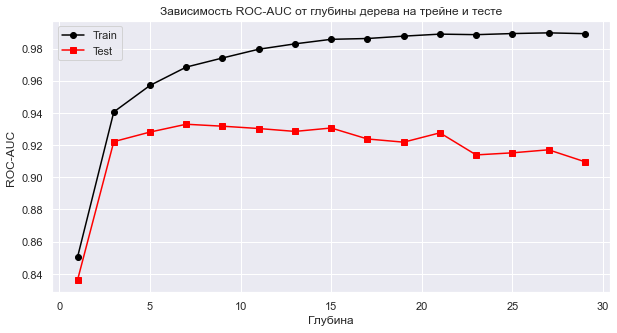

In [171]:
train_scores = []
test_scores = []
depths = list(range(1, 31, 2))
plt.figure(figsize=(15,15))
for depth in depths:
    boosting = Boosting(base_model_params={"max_depth": depth})
    boosting.fit(x_train, y_train, x_valid, y_valid) 
    train_scores.append(boosting.score(x_train, y_train))
    test_scores.append(boosting.score(x_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(depths, train_scores, marker='o', color='black', label='Train')
plt.plot(depths, test_scores, marker='s', color='red', label='Test')
plt.title('Зависимость ROC-AUC от глубины дерева на трейне и тесте')
plt.xlabel('Глубина')
plt.ylabel('ROC-AUC ')
plt.legend()
plt.show();

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

на трейне лучше, так как чем глубже деревья, тем больше мы подстраиваемся под обучающую выборку, а значит на новых данных будем показывать более плохой результат и модель будет иметь не очень хорошую обобщающую способность

## Задание 3. Подбираем гиперпараметры и ищем лучшую модель (3 балла)

Подберите по валидационной выборке основные гиперпараметры для вашей модели бустинга. Следует подобрать все основные параметры для самого градиентного бустинга и для самих базовых моделей. Существуют библиотеки для подбора гиперпараметров, попробуйте использовать какую-нибудь из следующих двух - [Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://optuna.org/).

In [172]:
import optuna

def params(trial):
    base_model_params = {
        'max_depth': trial.suggest_int('max_depth', 2, 42),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
    }
    
    boosting_params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 5, 20),
    }    
    booster = Boosting(base_model_params=base_model_params, **boosting_params)   
    booster.fit(x_train, y_train, x_valid, y_valid)   
    roc_auc = booster.score(x_valid, y_valid)   
    return roc_auc

learning = optuna.create_study(direction='maximize')
learning.optimize(params, n_trials=10)  

print(learning.best_params)
print(learning.best_value)

boosting_params = learning.best_trial.params
final_model = Boosting(base_model_params={'max_depth': boosting_params['max_depth'],
                                           'min_samples_split': boosting_params['min_samples_split']},
                        n_estimators=boosting_params['n_estimators'],
                        learning_rate=boosting_params['learning_rate'],
                        subsample=boosting_params['subsample'],
                        early_stopping_rounds=boosting_params['early_stopping_rounds'])

final_model.fit(x_train, y_train, x_valid, y_valid)

final_score = final_model.score(x_test, y_test)
print("Итоговый ROC-AUC для лучшей модели на тесте:", final_score)


[I 2023-12-23 23:39:43,393] A new study created in memory with name: no-name-eeae09c6-395b-4e66-8919-a7f7dd341f18
[I 2023-12-23 23:40:01,359] Trial 0 finished with value: 0.9311344768217313 and parameters: {'max_depth': 42, 'min_samples_split': 64, 'n_estimators': 53, 'learning_rate': 0.5011699505671395, 'subsample': 0.8126986674497395, 'early_stopping_rounds': 11}. Best is trial 0 with value: 0.9311344768217313.
[I 2023-12-23 23:40:14,124] Trial 1 finished with value: 0.9398838472485957 and parameters: {'max_depth': 15, 'min_samples_split': 93, 'n_estimators': 81, 'learning_rate': 0.06519628149799557, 'subsample': 0.5474825294552272, 'early_stopping_rounds': 9}. Best is trial 1 with value: 0.9398838472485957.
[I 2023-12-23 23:40:25,793] Trial 2 finished with value: 0.939423291053157 and parameters: {'max_depth': 15, 'min_samples_split': 41, 'n_estimators': 40, 'learning_rate': 0.052054078451676825, 'subsample': 0.7890039175802452, 'early_stopping_rounds': 7}. Best is trial 1 with valu

{'max_depth': 5, 'min_samples_split': 38, 'n_estimators': 86, 'learning_rate': 0.3918423506529422, 'subsample': 0.9872474673600918, 'early_stopping_rounds': 17}
0.941111864071269
Итоговый ROC-AUC для лучшей модели на тесте: 0.939537302223349


## Задание 4. Интерпретация бустингового (2 балл)

Постройте калибровочную кривую для вашей лучшей модели бустинга. Насколько хорошо бустинг оценивает вероятности? Постройте также калибровочную кривую для логистической регрессии, сравните их между собой. Проанализируйте полученные результаты.

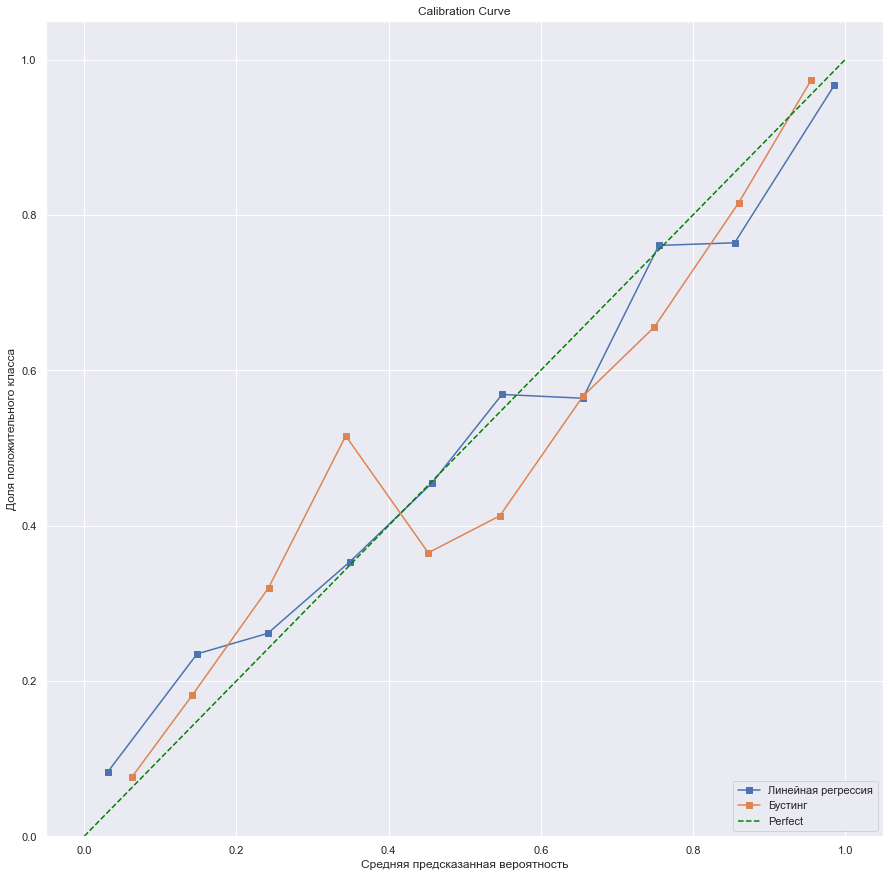

In [175]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve

lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)
lr_prob = lr_model.predict_proba(x_test)[:, 1]
lr_pos, lr_pred_mean = calibration_curve(y_test, lr_prob, n_bins=10)

bst_model = Boosting(
    base_model_params={'max_depth': 5, 'min_samples_split': 38},
    n_estimators=81,
    learning_rate=0.3918423506529422,
    subsample=0.9872474673600918,
    early_stopping_rounds=17
)
bst_model.fit(x_train, y_train, x_test, y_test)
bst_prob = bst_model.predict_proba(x_test)[:, 1]
bst_pos, bst_pred_mean = calibration_curve(y_test, bst_prob, n_bins=10)


plt.figure(figsize=(15,15))
plt.plot(lr_pred_mean, lr_pos, 's-', label='Линейная регрессия')
plt.plot(bst_pred_mean, bst_pos, "s-", label="Бустинг")
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Доля положительного класса')
plt.title('Calibration Curve')
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.show()

**Ответ**: стоит, наверное, дополнительно откалибровывать нашу бустинговую модель, тк основная цель бустинга - точная классификация, а не точная оценка вероятностей, поэтому для некоторых объектов модель может быть слишком уверенной или наоборот. Точность оценки вероятностей может зависеть от различных факторов: алгоритм бустинга, данные (мб в данных какой-то шум), используемые для обучения, и параметры модели. Но стоит сказать, что на графике выше как будто и линейная регрессия, которая по сути своей накладывает сигмоиду и преобразовывает линейные комбинации в вероятности принадлежности положительному классу, не идеально откалибрована, но она менее резко меняет движение от точки к точке и лежит ближе к идеальной прямой

Теперь попробуем оценить важность признаков для бустинга.

Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так).

Допишите в вашей реализации бустинга функцию `feature_importances_` чтобы она возвращала описанные выше важности признаков.

Нарисуйте столбчатую диаграмму важности признаков. На соседнем графике нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики. Проанализируйте полученные результаты.

_**Ответ**_: Важности признаков для бустинга и логистической регрессии сильно отличаются, это может говорить о различиях в их способности моделировать зависимости. Если признаки, которые важны для бустинга, имеют незначительное влияние для логистической регрессии, это может означать, что бустинг лучше улавливает нелинейные зависимости в данных.





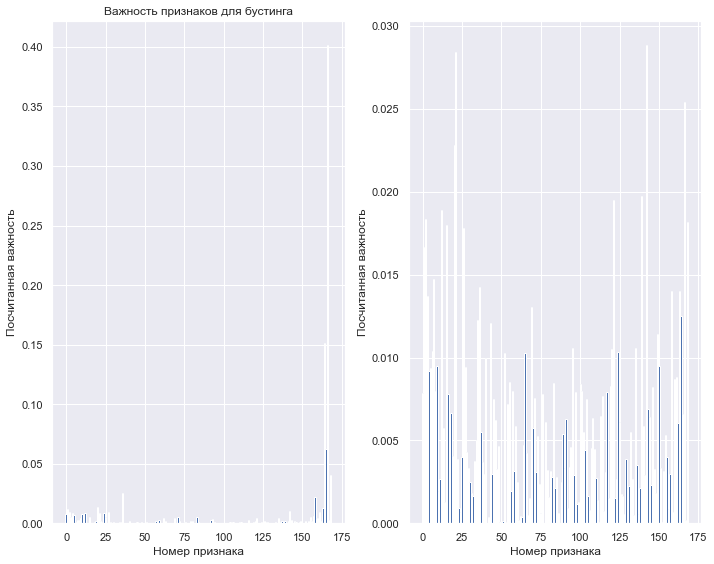

In [181]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)

feature_importances = bst_model.feature_importances_
plt.bar(range(len(feature_importances)), feature_importances)
plt.title("Важность признаков для бустинга")
plt.xlabel("Номер признака")
plt.ylabel("Посчитанная важность")

log_reg_importances = np.abs(lr_model.coef_[0])
log_reg_importances /= log_reg_importances.sum()
plt.subplot(1, 2, 2)
plt.bar(range(len(log_reg_importances)), log_reg_importances)
plt.xlabel("Номер признака")
plt.ylabel("Посчитанная важность")
plt.tight_layout();

Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (с теми же гиперпараметрами). Стало ли лучше?

In [184]:
feature_importances = bst_model.feature_importances_
threshold = np.median(feature_importances) #выбираем половину важных признаков
important_features = [i for i, importance in enumerate(feature_importances) if importance > threshold]

X_train_filtered = x_train[:, important_features]
X_test_filtered = x_test[:, important_features]
X_valid_filtered =  x_valid[:, important_features]


bst_model_filtered = Boosting(
    base_model_params={'max_depth': 5, 'min_samples_split': 38},
    n_estimators=81,
    learning_rate=0.3918423506529422,
    subsample=0.9872474673600918,
    early_stopping_rounds=17
)

bst_model_filtered.fit(X_train_filtered, y_train, X_valid_filtered, y_valid)

In [185]:
final_score = bst_model_filtered.score(X_test_filtered, y_test)
print(f'Значение ROC-AUC на тесте с отфильтрованными признаками {final_score:.4f}')
#результат стал чуточку лучше

Значение ROC-AUC на тесте с отфильтрованными признаками 0.9400


## Задание 5 (бонус). Блендинговое (1 балл)

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [193]:
predictions_bst = bst_model_filtered.predict_proba(X_train_filtered)[:, 1]

lr_model = LogisticRegression()
lr_model.fit(X_train_filtered, y_train) # обучаем также на отобранных лучших признаках
predictions_lr = lr_model.predict_proba(X_train_filtered)[:, 1]

blending_train = np.column_stack((predictions_bst, predictions_lr))
blending_model = LogisticRegression()
blending_model.fit(blending_train, y_train)
predictions_blending_valid = blending_model.predict_proba(blending_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, predictions_blending_valid)

print(f"Рок-аук при блендинге для валидации: {roc_auc:.4f}")

predictions_bst_test = bst_model_filtered.predict_proba(X_test_filtered)[:, 1]
predictions_lr_test = lr_model.predict_proba(X_test_filtered)[:, 1]
blending_test = np.column_stack((predictions_bst_test, predictions_lr_test))
predictions_blending_test = blending_model.predict_proba(blending_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, predictions_blending_test)

print(f"Рок-аук при блендинге для теста: {roc_auc_test:.4f}")
#чуть получше стало

Рок-аук при блендинге для валидации: 0.9442
Рок-аук при блендинге для теста: 0.9413


## Задание 6 (бонус). Катбустовое (1 балл)

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [196]:
from catboost import CatBoostClassifier
model = CatBoostClassifier()
#обучаем на изначальной выборке до удаления признаков
model.fit(x_train, y_train, eval_set=(x_valid, y_valid), verbose=False)
val_pred_proba = model.predict_proba(x_valid)[:, 1]
test_pred_proba = model.predict_proba(x_test)[:, 1]
val_roc_auc = roc_auc_score(y_valid, val_pred_proba)
test_roc_auc = roc_auc_score(y_test, test_pred_proba)

print(f"ROC AUC на валидационной выборке: {val_roc_auc:.4f}")
print(f"ROC AUC на тесте: {test_roc_auc:.4f}")
#на обеих выборках получше (если сравнивать с результатами до подбора гиперпараметров и отбора признаков)

ROC AUC на валидационной выборке: 0.9473
ROC AUC на тесте: 0.9408


In [198]:
#теперь катбуст на отобранных ранее признаках
model.fit(X_train_filtered, y_train, eval_set=(X_valid_filtered, y_valid), verbose=False)
val_pred_proba = model.predict_proba(X_valid_filtered)[:, 1]
test_pred_proba = model.predict_proba(X_test_filtered)[:, 1]
val_roc_auc = roc_auc_score(y_valid, val_pred_proba)
test_roc_auc = roc_auc_score(y_test, test_pred_proba)

print(f"ROC AUC на валидационной выборке: {val_roc_auc:.4f}")
print(f"ROC AUC на тесте: {test_roc_auc:.4f}")
#на валидационной выборке получше, на тесте - тот же (но мы здесь гиперпараметры не подбирали
#и для катбуста могут быть важными другие признаки

ROC AUC на валидационной выборке: 0.9472
ROC AUC на тесте: 0.9413


## Социализационный бонус. Новогоднее 🎆 (0.5 балла)

Сфотографируйтесь с наряженной новогодней или рождественской ёлкой! Приложите фотографию, опишите свои впечатления, чего вы ждете от нового 2024 года?

впечатления нереальные просто вау, желаю себе и вам в 2024 году высыпаться, это будет в новинку

Единственная доступная мне на данный момент елка. Любители мо-1.


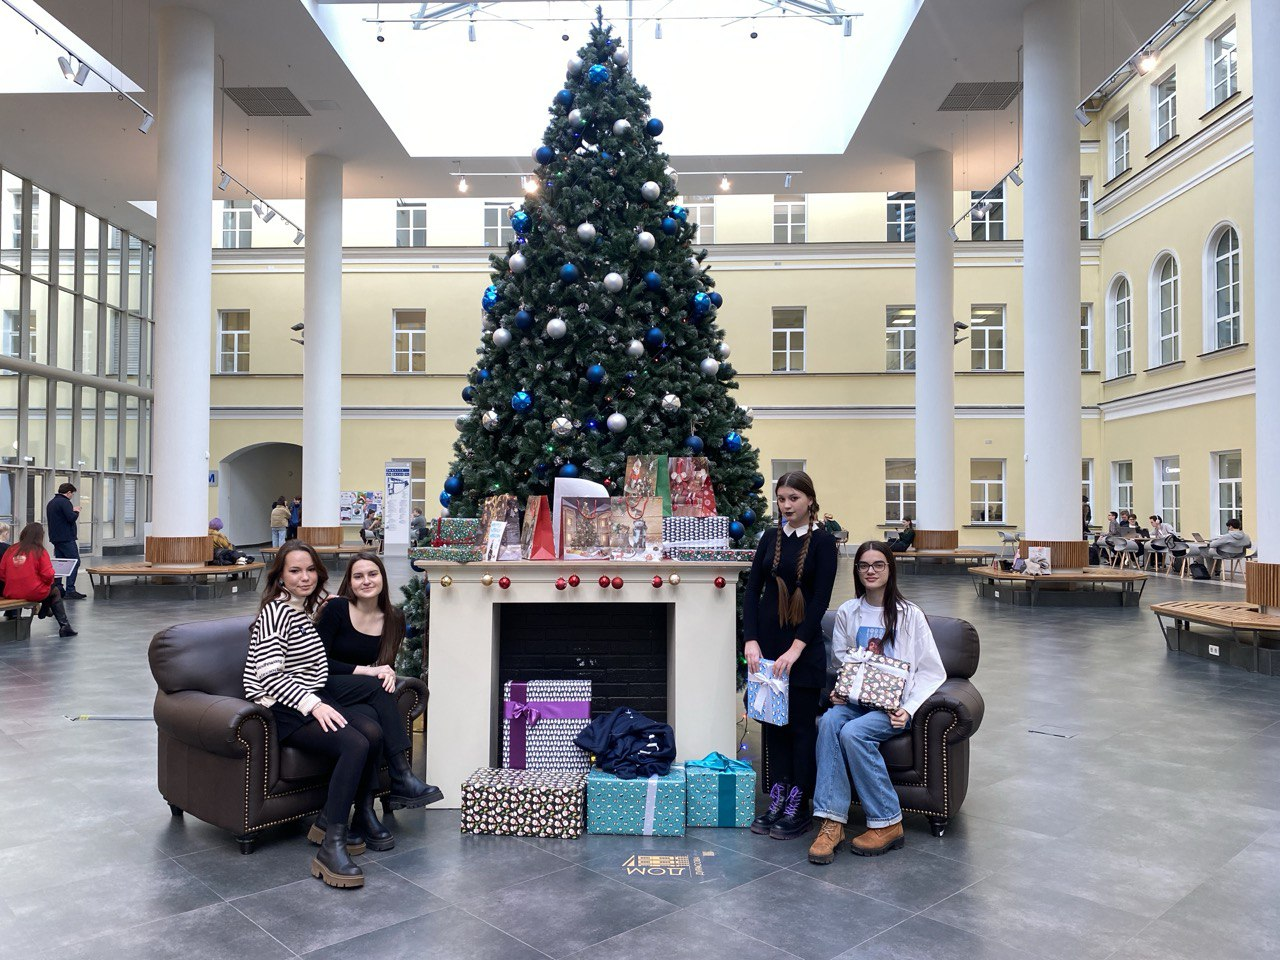

In [202]:
from IPython.display import Image
print('Единственная доступная мне на данный момент елка. Любители мо-1.')
Image(r"C:\Users\murad\OneDrive\Рабочий стол\ель.jpg", width=500, height=500)